In [1]:
import sys
sys.path.insert(1, 'C:/Users/raena/Documents/Imperial College London/msc_thesis/code/functions_and_classes')

from dataRead import *
from glob import glob
import pandas as pd
import numpy as np

## Check EQW over whole period

In [2]:
# Get DJI Index weights data per quarter

DJI_weights_paths = glob('../../data/dataBBG/DJI_index_weights/DJI_*.pickle')
DJI_weights_per_quarter = {}
for path in DJI_weights_paths:
    date = path.split('.')[-2].split('_')[-1]
    DJI_weights_per_quarter[date] = pd.read_pickle(path)

# Import price and volume data for each stock in the DJI Index
DJI_PX_LAST_paths = glob('../../data/dataBBG/DJI_stock_PX_LAST/* Equity.pickle')
DJI_PX_VOLUME_paths = glob('../../data/dataBBG/DJI_stock_PX_VOLUME/* Equity.pickle')

DJI_price_data = {}
DJI_volume_data = {}

for path in DJI_PX_LAST_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    # if ticker == '3277Q UN': # JP Morgan
    #     path = '../../data/dataBBG/DJI_stock_PX_LAST/JPM UN Equity.pickle'
    df = pd.read_pickle(path).set_index('date')
    df.index = pd.to_datetime(df.index)
    DJI_price_data[ticker] = df

for path in DJI_PX_VOLUME_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    df = pd.read_pickle(path).set_index('date')
    df.index = pd.to_datetime(df.index)
    # df.index = pd.to_datetime(df.index)
    DJI_volume_data[ticker] = df

trading_days = pd.to_datetime(list(DJI_price_data['AAPL'].index))

# Matrix Conditioning (RMT)

N = 5, 6,..., 60

In [3]:
from covarianceMatrixVolume import *
from thresholdVectors import *
qDates = list(DJI_weights_per_quarter.keys())
n_q = len(qDates)

k = -1
dat = qDates[k-4]
datend = str(int(qDates[k]) - 1)
weights_data = DJI_weights_per_quarter[dat]
members = weights_data.sort_values(by = 'Weight', ascending = False)['INDX_MWEIGHT_HIST']
prices = pd.DataFrame({ticker: DJI_price_data[ticker]['PX_LAST'] for ticker in DJI_price_data.keys()})
volumes = pd.DataFrame({ticker: DJI_volume_data[ticker]['PX_VOLUME'] for ticker in DJI_price_data.keys()})
tempR = np.log(prices.loc[str(dat):str(datend),members]).diff(1).iloc[1:] # log returns
tempV = volumes.loc[str(dat):str(datend),members].iloc[1:] 
tempV = np.log(tempV)
tempV = (tempV - tempV.mean(axis=0))/tempV.std(axis = 0, ddof=1)

In [4]:
assets = ['AAPL','GS']
tempR = tempR[assets]
tempV = tempV[assets]
x = tempR[assets[0]]
y = tempR[assets[1]]
z0 = tempV[assets[0]]
z1 = tempV[assets[1]]

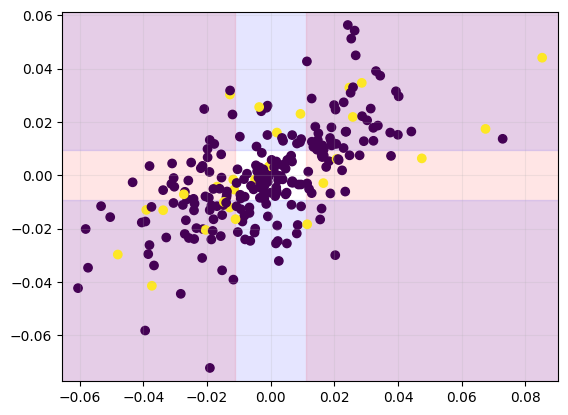

In [11]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
c = 0.5
a = .01
ax.fill_between([x.min()-a, -c*x.std()], y.min()-a, y.max()+a, alpha = 0.1, color = 'red')
ax.fill_between([c*x.std(), x.max()+a], y.min()-a, y.max()+a, alpha = 0.1, color = 'red')
ax.fill_between([x.min()-a, x.max()+a], y.min()-a, -c*y.std(), alpha = 0.1, color = 'blue')
ax.fill_between([x.min()-a, x.max()+a], c*y.std(), y.max()+a, alpha = 0.1, color = 'blue')
ax.scatter(x, y, c = (tempV > 0.5).prod(axis = 1))
ax.set_xlim(x.min()-(a/2), x.max()+(a/2))
ax.set_ylim(y.min()-(a/2), y.max()+(a/2))
ax.grid(alpha=0.2)